# 변경이 필요한 부분

GPT-1 모델은 기본적으로 트랜스포머 디코더(Transformer Decoder) 구조를 사용합니다. 따라서 전체적인 구조는 실습시 사용했던 트랜스포머 구조와 유사하지만, 몇가지 변경해야할 사항들이 있습니다.

먼저 GPT-1은 디코더 블록만 사용하므로, 트랜스포머와 같은 인코더-디코더 어텐션(encoder-decoder attention) 레이어가 없습니다. GPT-1은 오직 이전 토큰에만 의존해 다음 토큰을 생성합니다. 그리고 단일의 연속된 토큰 시퀀스를 입력으로 받습니다  
또한 GPT-1은 비지도 언어 모델링이라는 목표를 가지고 있습니다. GPT는 두가지 학습단계 1.unsupervised pre-training ,2.supervised fine-tuning를 통해 최소한의 구조 변화로 Target task에 transfer 합니다.

# 필요 모듈 임포트

In [1]:
import torch
print(torch.__version__)

2.8.0+cu126


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# 챗봇 데이터 다운로드 및 EDA

In [3]:
!mkdir -p /content/transformer_chatbot/data && cd /content/transformer_chatbot/data && wget 'https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv'

--2025-08-20 07:13:54--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-08-20 07:13:54--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2025-08-20 07:13:54 (28.3 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [4]:
import pandas as pd

df = pd.read_csv('/content/transformer_chatbot/data/ChatbotData.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [6]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [7]:
df['label'].value_counts()

,count
label,
0,5290
1,3570
2,2963


In [8]:
df['Q'].str.len()

,Q
0,6
1,11
2,12
3,15
4,7
...,...
11818,14
11819,14
11820,11
11821,23


In [9]:
df['A'].str.len()

,A
0,10
1,9
2,11
3,11
4,10
...,...
11818,18
11819,13
11820,6
11821,24


In [10]:
df['q_len'] = df['Q'].str.len()
df['a_len'] = df['A'].str.len()

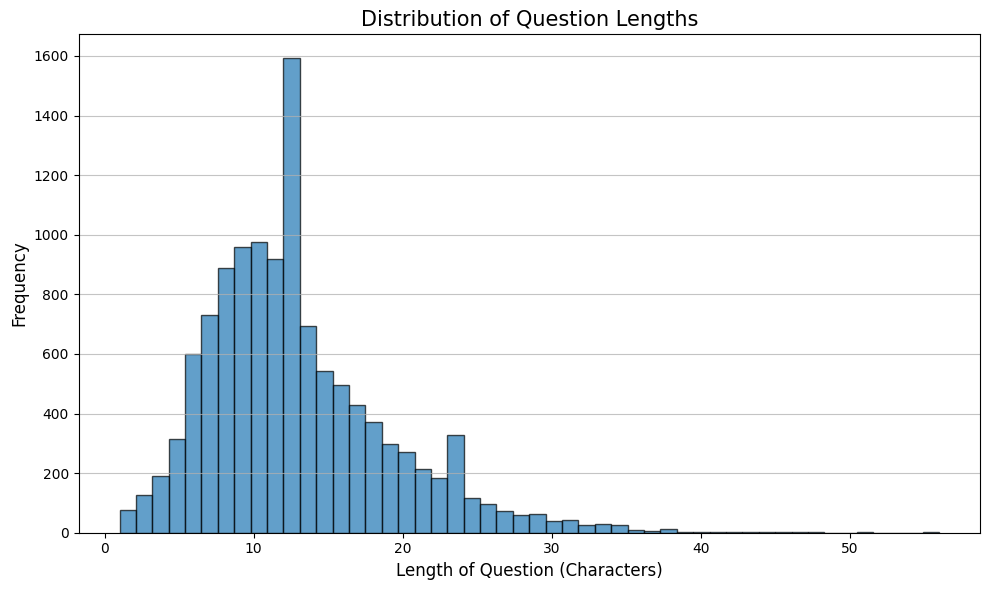

In [11]:
# 질문 길이 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df['q_len'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Question Lengths', fontsize=15)
plt.xlabel('Length of Question (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


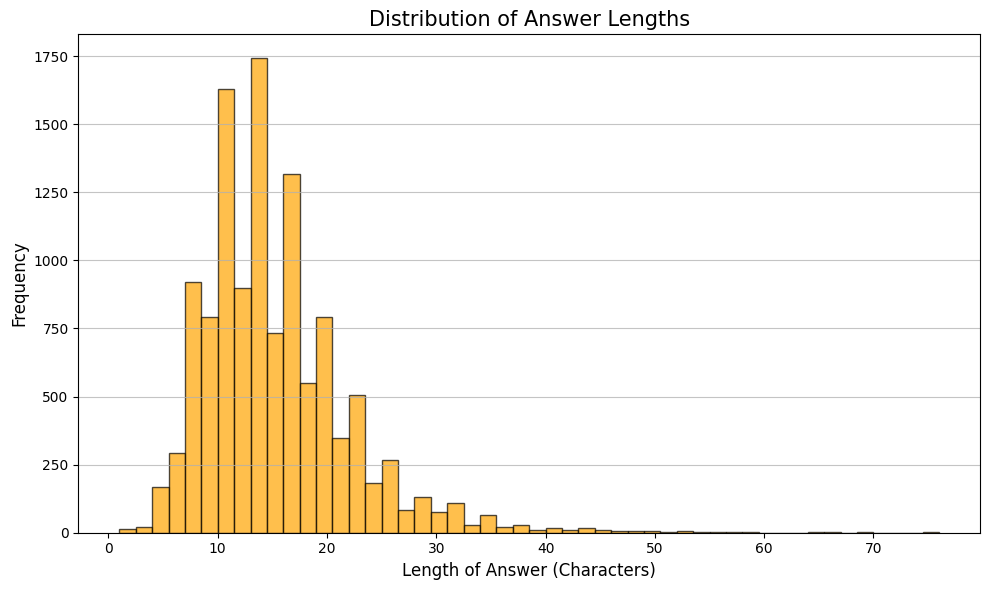

In [12]:
# 답변 길이 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df['a_len'], bins=50, edgecolor='k', alpha=0.7, color='orange')
plt.title('Distribution of Answer Lengths', fontsize=15)
plt.xlabel('Length of Answer (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

라벨값 분포와 Q,A 길이를 확인했다. 각 50자,30자 내에서 질답이 형성되어있다.

# 데이터 로드 및 전처리

 GPT-1 논문에 따르면, 모델의 입력은 단일의 연속된 토큰 시퀀스여야 합니다. 이 프로젝트를 위한 전처리 과정은 다음과 같이 진행되어야 합니다.


In [13]:
# 질문(Q)과 답변(A) 데이터를 결합하여 단일 시퀀스로 만듭니다.
# GPT-1은 단일의 연속된 토큰 시퀀스를 입력으로 받기 때문입니다.
combined_text = pd.concat([df['Q'], df['A']])

# 결합된 데이터의 일부를 확인
print("결합된 데이터의 상위 5개 항목:")
print(combined_text.head())

print("\n결합된 데이터의 하위 5개 항목:")
print(combined_text.tail())

결합된 데이터의 상위 5개 항목:
0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
dtype: object

결합된 데이터의 하위 5개 항목:
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
dtype: object


### SentencePiece를 이용한 토큰화

In [14]:
# SentencePiece 모델 학습을 위한 파일로 저장
with open("chatbot_text.txt", "w", encoding="utf-8") as f:
    for text in combined_text:
        f.write(str(text) + "\n")

# SentencePiece 모델 학습
# vocab_size는 필요에 따라 조정 가능합니다.
# special_tokens 매개변수를 사용하여 학습 시 특수 토큰을 포함시킵니다.
special_tokens = ['<|startoftext|>', '<|endoftext|>', '<|pad|>']
spm.SentencePieceTrainer.train(
    '--input=chatbot_text.txt --model_prefix=chatbot_spm --vocab_size=8000 --character_coverage=1.0 --user_defined_symbols=' + ','.join(special_tokens))


# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.load('chatbot_spm.model')

print("\nSentencePiece 모델 학습 및 로드 완료.")


SentencePiece 모델 학습 및 로드 완료.


### 특수 토큰 추가 및 토큰화 적용

In [15]:
# 특수 토큰 정의
START_TOKEN = '<|startoftext|>'
END_TOKEN = '<|endoftext|>'
PAD_TOKEN = '<|pad|>'

# 특수 토큰 ID 확인
# user_defined_symbols로 추가했으므로 piece_to_id로 ID를 가져옵니다.
START_TOKEN_ID = sp.piece_to_id(START_TOKEN)
END_TOKEN_ID = sp.piece_to_id(END_TOKEN)
PAD_TOKEN_ID = sp.piece_to_id(PAD_TOKEN)

print(f"'{START_TOKEN}' ID: {START_TOKEN_ID}")
print(f"'{END_TOKEN}' ID: {END_TOKEN_ID}")
print(f"'{PAD_TOKEN}' ID: {PAD_TOKEN_ID}")


# 데이터를 토큰 ID 시퀀스로 변환하고 특수 토큰 추가
tokenized_data = []
for text in combined_text:
    # 각 시퀀스의 시작과 끝에 특수 토큰 추가
    token_ids = [START_TOKEN_ID] + sp.encode_as_ids(str(text)) + [END_TOKEN_ID]
    tokenized_data.append(token_ids)

print("\n데이터 토큰화 및 특수 토큰 추가 완료.")
print("첫 번째 토큰화된 시퀀스:", tokenized_data[0])
print("첫 번째 시퀀스 디코딩:", sp.decode_ids(tokenized_data[0]))

'<|startoftext|>' ID: 3
'<|endoftext|>' ID: 4
'<|pad|>' ID: 5

데이터 토큰화 및 특수 토큰 추가 완료.
첫 번째 토큰화된 시퀀스: [3, 4297, 551, 7, 7826, 66, 4]
첫 번째 시퀀스 디코딩: <|startoftext|> 12시 땡!<|endoftext|>


### 패딩 적용 및 데이터셋 준비

In [16]:
# 필요한 라이브러리 임포트 (혹시 모를 세션 끊김에 대비)
import torch
from torch.utils.data import Dataset, DataLoader

# PAD_TOKEN_ID 변수가 정의되어 있는지 확인
if 'PAD_TOKEN_ID' not in locals() and 'PAD_TOKEN_ID' not in globals():
    print("PAD_TOKEN_ID가 정의되지 않았습니다. 이전 셀에서 특수 토큰 ID를 먼저 확인해주세요.")
    # 기본값 또는 오류 처리를 수행할 수 있습니다.
    # 여기서는 실행을 중단하고 사용자에게 알립니다.
    raise NameError("PAD_TOKEN_ID is not defined.")


# 시퀀스 길이를 통일하기 위한 패딩
# EDA 과정에서 50자 내외인걸 알고 ㅁmax는 64로 뒀다
MAX_SEQUENCE_LENGTH = 64

padded_data = []
# tokenized_data 변수가 정의되어 있는지 확인
if 'tokenized_data' in locals() or 'tokenized_data' in globals():
    for token_ids in tokenized_data:
        if len(token_ids) > MAX_SEQUENCE_LENGTH:
            padded_seq = token_ids[:MAX_SEQUENCE_LENGTH]
        else:
            padding_length = MAX_SEQUENCE_LENGTH - len(token_ids)
            padded_seq = token_ids + [PAD_TOKEN_ID] * padding_length
        padded_data.append(padded_seq)

    padded_data = torch.tensor(padded_data, dtype=torch.long)

    print("\n데이터 패딩 완료.")
    print("패딩된 데이터 형태:", padded_data.shape)
    print("첫 번째 패딩된 시퀀스:", padded_data[0])

    # 데이터셋 클래스 정의
    class ChatbotDataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]

    # 데이터셋 및 데이터 로더 생성
    dataset = ChatbotDataset(padded_data)
    BATCH_SIZE = 32
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    print("데이터셋 및 데이터 로더 준비 완료.")
    print("데이터 로더의 첫 번째 배치 형태:", next(iter(dataloader)).shape)
else:
     print("\n'tokenized_data' 변수가 정의되지 않았습니다. 이전 셀에서 토큰화 및 특수 토큰 추가를 먼저 실행해주세요.")


데이터 패딩 완료.
패딩된 데이터 형태: torch.Size([23646, 64])
첫 번째 패딩된 시퀀스: tensor([   3, 4297,  551,    7, 7826,   66,    4,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5])
데이터셋 및 데이터 로더 준비 완료.
데이터 로더의 첫 번째 배치 형태: torch.Size([32, 64])


# GPT-1 모델 정의

In [17]:
# 필요한 라이브러리 임포트 (혹시 모를 세션 끊김에 대비)
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm # SentencePieceProcessor 객체 사용을 위해 임포트

# sp 객체가 정의되어 있는지 확인
if 'sp' not in locals() and 'sp' not in globals():
     print("sp가 정의되지 않았습니다. 이전 셀에서 SentencePiece 모델 로드를 먼저 실행해주세요.")
     # 기본값 또는 오류 처리를 수행할 수 있습니다.
     raise NameError("sp is not defined.")


class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask):
        # 마스킹된 셀프 어텐션
        attn_output, _ = self.self_attn(x, x, x, attn_mask=look_ahead_mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output) # Add and Norm

        # 피드포워드 네트워크
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(out1))))
        ff_output = self.dropout2(ff_output)
        out2 = self.norm2(out1 + ff_output) # Add and Norm
        return out2

class GPT1(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_seq_length, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_embedding = nn.Embedding(max_seq_length, d_model)
        self.layers = nn.ModuleList([
            TransformerDecoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_length = max_seq_length
        self.d_model = d_model

    def forward(self, x):
        seq_len = x.size(1)
        # 토큰 및 위치 임베딩
        token_embed = self.token_embedding(x)
        # position_ids를 x.device가 아닌 model의 device로 명시적으로 설정
        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=self.token_embedding.weight.device)
        position_embed = self.positional_embedding(position_ids).unsqueeze(0)
        x = self.dropout(token_embed + position_embed)

        # 마스킹된 셀프 어텐션을 위한 look ahead mask 생성
        # 현재 토큰 이후의 토큰을 보지 못하도록 가리는 마스크
        look_ahead_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()

        # 디코더 블록 통과
        for layer in self.layers:
            x = layer(x, look_ahead_mask)

        # 최종 선형 레이어
        output = self.linear(x)
        return output

# 모델 파라미터 설정 (GPT-1 논문의 base model 파라미터 참고)
# 논문에서는 N=12, H=12, d_model=768, d_ff=3072 를 사용했지만,
# 논문에서 명시한 데이터셋의 크기를 고려했을때, 코랩의 무료 gpu 성능을 고려하여 조정함
VOCAB_SIZE = sp.get_piece_size() # SentencePiece 어휘집 크기
D_MODEL = 256 # 임베딩 차원
NUM_LAYERS = 4 # 디코더 레이어 수
NUM_HEADS = 8 # 어텐션 헤드 수
D_FF = 1024 # 피드포워드 네트워크의 은닉층 차원
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH # 이전에 정의한 최대 시퀀스 길이
DROPOUT_RATE = 0.1 # 드롭아웃 비율

# GPT-1 모델 인스턴스 생성
model = GPT1(VOCAB_SIZE, D_MODEL, NUM_LAYERS, NUM_HEADS, D_FF, MAX_SEQUENCE_LENGTH, DROPOUT_RATE)

print("GPT-1 모델 정의 완료.")
print(model)

GPT-1 모델 정의 완료.
GPT1(
  (token_embedding): Embedding(8000, 256)
  (positional_embedding): Embedding(64, 256)
  (layers): ModuleList(
    (0-3): 4 x TransformerDecoderBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=256, out_features=8000, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


## 모델 학습

In [18]:
# 학습 설정
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID) # 패딩 토큰은 손실 계산에서 제외
optimizer = optim.Adam(model.parameters(), lr=0.001) # 학습률은 필요에 따라 조정

# 학습 장치 설정 (GPU 사용 가능 시)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"학습 장치: {device}")

# 학습 루프
num_epochs = 10 # 학습 에폭 수 (필요에 따라 조정)
history = {'loss': [], 'accuracy': []} # 정확도를 저장할 리스트 추가

print("모델 학습 시작...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in dataloader:
        batch = batch.to(device)

        # 입력 및 타겟 준비
        # 언어 모델링의 목표는 다음 토큰을 예측하는 것이므로, 입력 시퀀스의 각 토큰에 대한 타겟은 그 다음 토큰이 됩니다.
        # 마지막 토큰에 대한 타겟은 없으므로 시퀀스 길이는 1 줄어듭니다.
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        # 순전파
        outputs = model(inputs)

        # 손실 계산
        loss = criterion(outputs.reshape(-1, VOCAB_SIZE), targets.reshape(-1))

        # 정확도 계산 (패딩 토큰 제외)
        # 예측된 토큰 ID
        predicted_tokens = torch.argmax(outputs, dim=-1)
        # 패딩 토큰이 아닌 위치의 마스크
        non_pad_mask = (targets != PAD_TOKEN_ID)
        # 패딩이 아닌 위치에서의 정확도 계산
        correct_predictions += (predicted_tokens[non_pad_mask] == targets[non_pad_mask]).sum().item()
        total_predictions += non_pad_mask.sum().item()


        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0 # 0으로 나누는 것 방지

    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)

    print(f"에폭 [{epoch+1}/{num_epochs}], 손실: {epoch_loss:.4f}, 정확도: {epoch_accuracy:.4f}")

print("모델 학습 완료.")

학습 장치: cuda
모델 학습 시작...
에폭 [1/10], 손실: 5.9377, 정확도: 0.2097
에폭 [2/10], 손실: 5.1443, 정확도: 0.2625
에폭 [3/10], 손실: 4.5420, 정확도: 0.3007
에폭 [4/10], 손실: 4.0519, 정확도: 0.3348
에폭 [5/10], 손실: 3.6629, 정확도: 0.3662
에폭 [6/10], 손실: 3.3530, 정확도: 0.3976
에폭 [7/10], 손실: 3.1049, 정확도: 0.4273
에폭 [8/10], 손실: 2.9111, 정확도: 0.4525
에폭 [9/10], 손실: 2.7487, 정확도: 0.4758
에폭 [10/10], 손실: 2.6174, 정확도: 0.4973
모델 학습 완료.


오 지난 실습보단 결과가 더 좋다! 작은 모델에서는 스케쥴러를 안쓰는것도 좋은 방법이겠다!

# 모델 평가 및 텍스트 생성

평가 모드 설정/텍스트 생성 함수 구현/특수 토큰 처리  
이 3 단계의 과정으로 진행함

In [43]:
def generate_text(model, sp, start_sequence, max_length=100, temperature=1.0, top_k=None, device="gpu"):
    model.eval() # 평가 모드

    # 시작 시퀀스를 토큰 ID로 변환
    start_token_ids = [sp.piece_to_id(START_TOKEN)] + sp.encode_as_ids(start_sequence)
    input_ids = torch.tensor([start_token_ids], dtype=torch.long, device=device)

    generated_sequence = start_token_ids

    with torch.no_grad():
        for _ in range(max_length - len(start_token_ids)):
            # 모델 입력은 현재까지 생성된 시퀀스
            outputs = model(input_ids)
            # 마지막 토큰의 예측 확률 분포 가져오기
            logits = outputs[:, -1, :] / temperature

            if top_k is not None:
                # Top-k 샘플링
                top_logits, top_indices = torch.topk(logits, top_k)
                probabilities = F.softmax(top_logits, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1).squeeze()
                next_token_id = top_indices.squeeze()[next_token_id]
            else:
                # 확률 분포에서 샘플링
                probabilities = F.softmax(logits, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1).squeeze()

            # 생성된 토큰 ID 추가
            generated_sequence.append(next_token_id.item())

            # 다음 입력을 위해 시퀀스 업데이트
            input_ids = torch.tensor([generated_sequence], dtype=torch.long, device=device)

            # 종료 토큰이 생성되면 중지
            if next_token_id.item() == sp.piece_to_id(END_TOKEN):
                break

    # 토큰 ID 시퀀스를 텍스트로 디코딩
    # 특수 토큰과 패딩 토큰 제외
    generated_text = sp.decode_ids([id for id in generated_sequence if id not in [sp.piece_to_id(START_TOKEN), sp.piece_to_id(END_TOKEN), sp.piece_to_id(PAD_TOKEN)]])

    return generated_text

# 텍스트 생성 예시
start_prompt = "오늘 기분이"
generated_text = generate_text(model, sp, start_prompt, max_length=64, temperature=0.8, top_k=50, device=device)

print(f"시작 프롬프트: '{start_prompt}'")
print(f"생성된 텍스트: '{generated_text}'")

시작 프롬프트: '오늘 기분이'
생성된 텍스트: '오늘 기분이 좋아'



#회고
PyTorch를 사용하여 트랜스포머 디코더 구조를 기반으로 하는 GPT-1 모델을 구현하였다. 학습된 모델로 텍스트 생성 함수를 구현하였다. 주어진 시작 프롬프트에 대해 모델이 생성한 텍스트를 확인했다.  
또한 sentencepiece로 전처리를 진행하였는데, 검색해보니 이는 구글이 개발한 토크나이저로, open ai는 아마 다른 방법으로 토큰화를 진행했을거 같다. 이를 찾아 다시 전처리를 진행한다면 gpt-1 을 따라서 구현하는 목표에 더 잘 들어맞을 것 같다.